In [ ]:
import pydicom
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from scipy.ndimage import map_coordinates

In [ ]:
data_dir_1 = './Tarea_1/datos/data_1'
output_csv_data_1 = 'patient_info_data1.csv'
output_data_1_anon = './Tarea_1/datos/data_1_anon'

data_dir_2 = './Tarea_1/datos/data_2'

p5_filepath = './Tarea_1/datos/p5.dcm'

## 3.1

In [ ]:
patient_data = []

for filename in os.listdir(data_dir_1):

    filepath = os.path.join(data_dir_1, filename)

    if os.path.isfile(filepath):
        ds = pydicom.dcmread(filepath, force=True)

        patient_name = ds.get('PatientName', 'N/A') # Nombre
        birth_date = ds.get('PatientBirthDate', 'N/A') # Cumpleaños

        # Añadir los datos a una lista
        patient_data.append([patient_name, birth_date])
        print(f"Nombre: {patient_name}, Cumpleaños: {birth_date}")

total_pacientes = len(patient_data)
print(f"Total de pacientes procesados: {total_pacientes}")

if patient_data: # Solo escribir si se encontraron datos
    with open(output_csv_data_1, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # Escribir la cabecera
        writer.writerow(['PatientName', 'PatientBirthDate'])
        # Escribir los datos de los pacientes
        writer.writerows(patient_data)
        print(f"Datos escritos en {output_csv_data_1}")

Nombre: Débora Salas, Cumpleaños: 19770508
Nombre: Luis Chabert, Cumpleaños: 19830208
Nombre: Alejandro Chabert, Cumpleaños: 19791001
Nombre: Cesar Buendía, Cumpleaños: 19830729
Nombre: Germán Roncagliolo, Cumpleaños: 19770513
Nombre: Pablo Roncagliolo, Cumpleaños: 19830202
Nombre: Germán Salas, Cumpleaños: 19850204
Nombre: Pablo Buendía, Cumpleaños: 19850915
Nombre: Wael Veloz, Cumpleaños: 19770720
Nombre: Germán Buendía, Cumpleaños: 19830404
Nombre: Wael Veloz, Cumpleaños: 19850114
Nombre: Wael Weinstein, Cumpleaños: 19790504
Nombre: Wael Salas, Cumpleaños: 19751019
Nombre: Steren Veloz, Cumpleaños: 19851117
Nombre: Scarlett Salas, Cumpleaños: 19790118
Nombre: Germán Weinstein, Cumpleaños: 19771120
Nombre: Luis Veloz, Cumpleaños: 19790923
Nombre: Débora Chabert, Cumpleaños: 19810913
Nombre: Germán Lever, Cumpleaños: 19850103
Nombre: Germán Buendía, Cumpleaños: 19850401
Total de pacientes procesados: 20
Datos escritos en patient_info_data1.csv


## 3.2

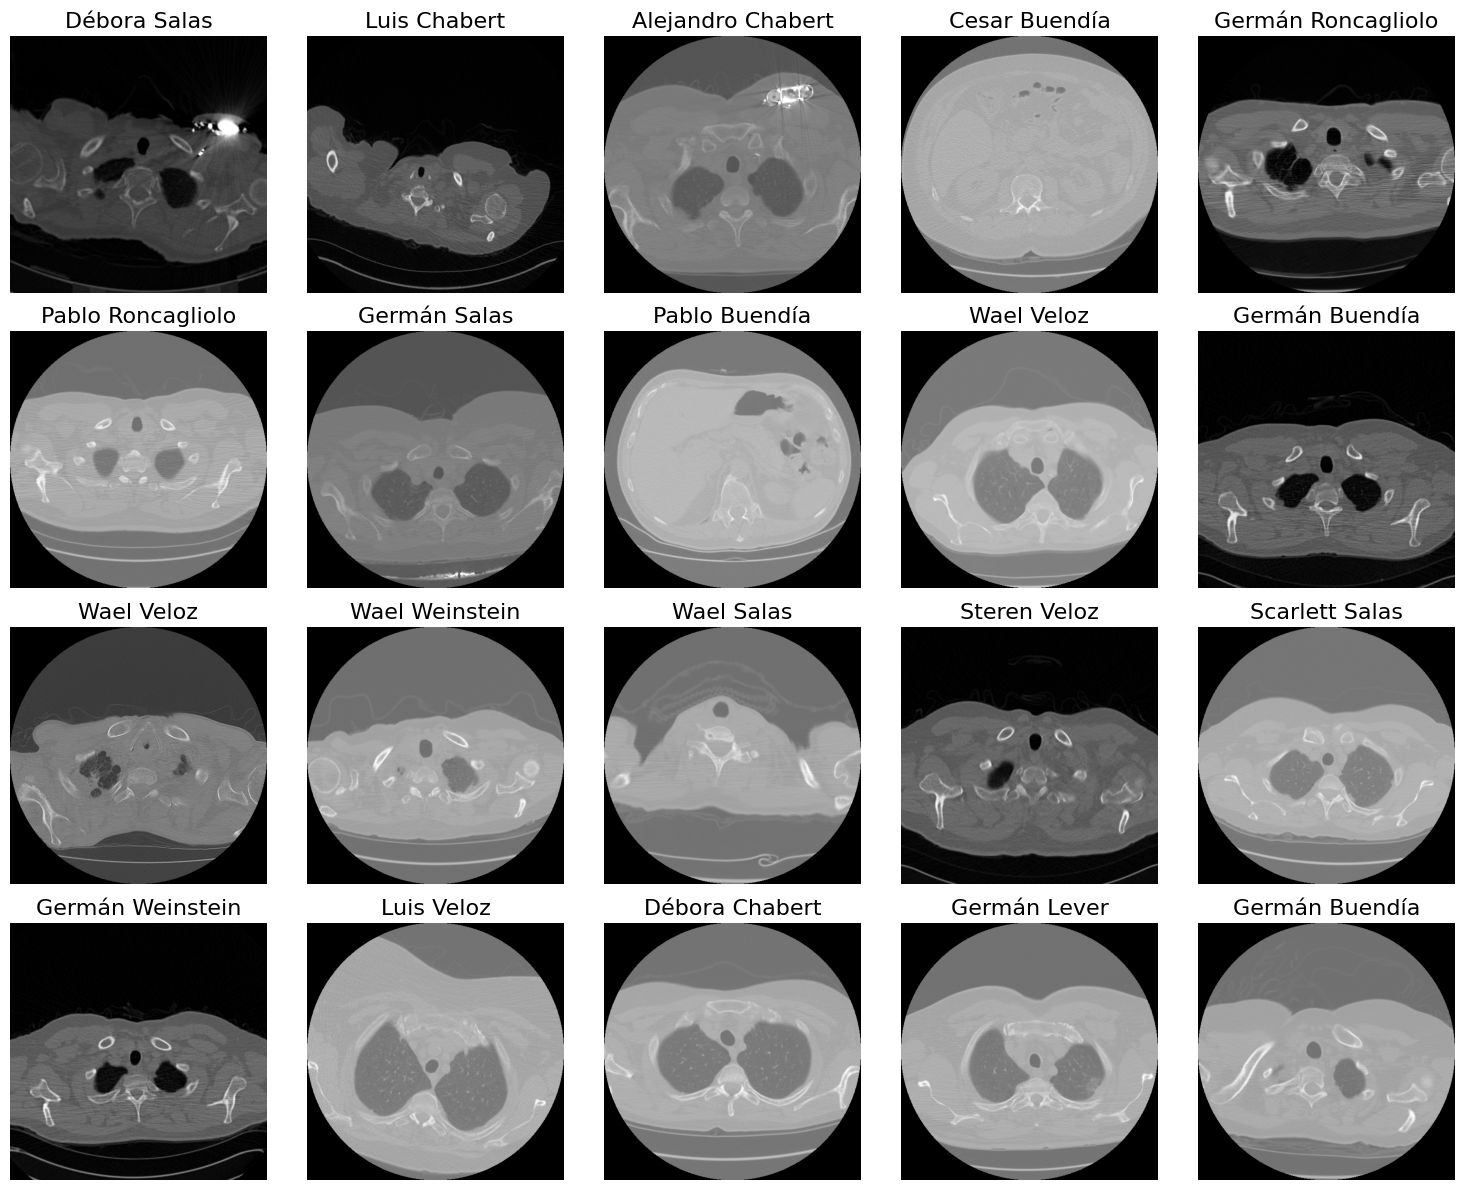

In [ ]:

dicom_files = []

for filename in os.listdir(data_dir_1):

    filepath = os.path.join(data_dir_1, filename)

    if os.path.isfile(filepath):

        dicom_files.append(filepath)

# leer
valid_datasets = []
patient_names = []

for filepath in dicom_files:

    ds = pydicom.dcmread(filepath) # lee pixeles


    if 'PixelData' in ds:

        patient_name_tag = ds.get('PatientName', 'Nombre Desconocido')
        if isinstance(patient_name_tag, pydicom.valuerep.PersonName):
            patient_name = str(patient_name_tag)

        valid_datasets.append(ds)
        patient_names.append(patient_name)


if valid_datasets:

    # dimensiones
    num_images = len(valid_datasets)

    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3)) # Ajusta el tamaño por subplot

    axes = axes.ravel()

    # Iterar sobre los datasets DICOM válidos y mostrarlos
    for i, ds in enumerate(valid_datasets):

        axes[i].imshow(ds.pixel_array, cmap=plt.cm.gray)
        # nombre del paciente
        axes[i].set_title(patient_names[i], fontsize=16)
        axes[i].axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## 3.2

In [ ]:
tags_to_anonymize = [
    'PatientName',        # (0010,0010)
    'PatientID',          # (0010,0020)
    'PatientBirthDate',   # (0010,0030)
    'PatientSex',         # (0010,0040)
    'PatientAddress',     # (0010,1040) - Si existe
    'PatientTelephoneNumbers', # (0010,2154) - Si existe
    'ReferringPhysicianName', # (0008,0090) - Si existe
    'InstitutionName',    # (0008,0080) - Si existe
    'OperatorsName',      # (0008,1070) - Si existe
    # Sacadas de chatGPT las dejo para saber cuales existen.
    # 'OtherPatientIDs', (0010,1000)
    # (0010, 1001) OtherPatientNames
    # (0010, 1010) PatientAge
    # (0010, 1060) PatientMotherBirthName
    # (0010, 2160) EthnicGroup
    # (0010, 4000) PatientComments
    # (0008, 0050) AccessionNumber
    # (0008, 1030) StudyDescription
    # (0008, 103E) SeriesDescription
    # (0008, 1040) InstitutionalDepartmentName
    # (0008, 1050) PerformingPhysicianName
    # (0008, 1060) NameOfPhysiciansReadingStudy
    # (0020, 000D) StudyInstanceUID - ¡Cuidado! Cambiar UIDs puede romper referencias
    # (0020, 000E) SeriesInstanceUID - ¡Cuidado!
    # (0008, 0018) SOPInstanceUID - ¡Cuidado!
]

# Función para anonimizar un dataset DICOM
def anonymize_dicom_dataset(ds):
    for tag_key in tags_to_anonymize:
        if tag_key in ds:

            data_element = ds.data_element(tag_key)
            if data_element.VR in ['LO', 'SH', 'PN', 'CS', 'AS', 'AE', 'LT', 'ST', 'UT', 'DA', 'TM', 'DT']:
                    ds[tag_key].value = '' # Asignar vacío
            else:
                    del ds[tag_key]

    # tiqueta indicando que el archivo fue modificado/anonimizado
    ds.add_new((0x0012, 0x0062), 'CS', 'YES')  # PatientIdentityRemoved
    ds.add_new((0x0012, 0x0063), 'LO', 'Anonimizado por script Tarea1') # DeidentificationMethod
    return ds



if os.path.isdir(data_dir_1):

    os.makedirs(output_data_1_anon, exist_ok=True) # exist_ok=True evita error si ya existe

    # Procesar cada archivo DICOM en la carpeta
    file_count = 0
    success_count = 0
    for filename in os.listdir(data_dir_1):
        input_filepath = os.path.join(data_dir_1, filename)
        output_filepath = os.path.join(output_data_1_anon, filename) # Mismo nombre, diferente carpeta

        if os.path.isfile(input_filepath):
            file_count += 1
            # Leer el archivo DICOM original (completo)
            ds = pydicom.dcmread(input_filepath)

            # Anonimizar el dataset
            ds_anon = anonymize_dicom_dataset(ds)

            # Guardar el dataset anonimizado en la carpeta de salida
            # ds_anon.save_as(output_filepath) # Alternativa
            pydicom.dcmwrite(output_filepath, ds_anon, write_like_original=True)
            print(f"Archivo anonimizado guardado: {output_filepath}")
            success_count += 1
    print(f"Total de archivos procesados: {file_count}")
    print(f"Total de archivos anonimizado: {success_count}")

Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\019787df3ae203ec160fb86dbee9275b.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\121969a3ea1dcd63ea14b7c8754098d3.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\16e2678d2ea8d8638f69a6f7b54eb030.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\22b3866a120110dde0ed9bfd73088e93.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\24cdd17911455e15811b3a330d625ce9.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\3d5a32fc7bc51b8c88ad46cce0354520.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\50cda0fb366c8e4b30766b3a435c3a40.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\53494c16c19ddf12a01ee4affd2a3181.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\5b5a722e6da741943f0f761ec4b4d7ec.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anon\6b9959c342ad8cc56e42e2e3905424d4.dcm
Archivo anonimizado guardado: ./Tarea_1/datos/data

## 3.4

In [ ]:
# Asegúrate de que la ruta data_dir_2 esté definida correctamente
# data_dir_2 = './Tarea_1/datos/data_2' # Ya debería estar definido en tu notebook

# Leer todos los archivos DICOM en el directorio data_2
dicom_files = [pydicom.dcmread(os.path.join(data_dir_2, f))
               for f in os.listdir(data_dir_2)
               if os.path.isfile(os.path.join(data_dir_2, f)) and f.endswith('.dcm')]

# Ordenar los archivos basados en InstanceNumber o SliceLocation si están disponibles
# Usaremos InstanceNumber como ejemplo, ajusta si es necesario
try:
    dicom_files.sort(key=lambda x: int(x.InstanceNumber))
except AttributeError:
    print("Advertencia: InstanceNumber no encontrado, intentando ordenar por SliceLocation.")
    try:
         dicom_files.sort(key=lambda x: float(x.SliceLocation))
    except AttributeError:
        print("Advertencia: Ni InstanceNumber ni SliceLocation encontrados. El orden puede ser incorrecto.")


# Apilar los datos de los píxeles en un volumen 3D
# Asumimos que todos los cortes tienen las mismas dimensiones
volume_3d = np.stack([ds.pixel_array for ds in dicom_files])

# Obtener las dimensiones del volumen
depth, height, width = volume_3d.shape
print(f"Volumen cargado con dimensiones (profundidad, alto, ancho): {volume_3d.shape}")

# Obtener espaciado entre píxeles y grosor del corte (si está disponible) para el aspect ratio
try:
    pixel_spacing = dicom_files[0].PixelSpacing # [row_spacing, col_spacing]
    slice_thickness = dicom_files[0].SliceThickness
except AttributeError:
    print("Advertencia: PixelSpacing o SliceThickness no encontrados. Usando aspect ratio 1.")
    pixel_spacing = [1, 1]
    slice_thickness = 1

aspect_sagittal = pixel_spacing[1] / slice_thickness
aspect_coronal = pixel_spacing[0] / slice_thickness
aspect_axial = pixel_spacing[1] / pixel_spacing[0]

print(f"Pixel Spacing: {pixel_spacing}, Slice Thickness: {slice_thickness}")
print(f"Aspect Ratios - Sagittal: {aspect_sagittal}, Coronal: {aspect_coronal}, Axial: {aspect_axial}")

def plot_sagittal(slice_index):
    plt.figure(figsize=(8, 8))
    plt.imshow(volume_3d[:, :, slice_index].T, cmap='gray', aspect=aspect_sagittal) # Transponer para vista sagital
    plt.title(f'Corte Sagital (X = {slice_index})')
    plt.xlabel("Eje Y")
    plt.ylabel("Eje Z (Profundidad)")
    plt.gca().invert_yaxis() # Invertir eje Z para orientación estándar
    plt.show()

def plot_coronal(slice_index):
    plt.figure(figsize=(8, 8))
    plt.imshow(volume_3d[:, slice_index, :].T, cmap='gray', aspect=aspect_coronal) # Transponer para vista coronal
    plt.title(f'Corte Coronal (Y = {slice_index})')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Z (Profundidad)")
    plt.gca().invert_xaxis() # Invertir eje X para vista estándar
    plt.gca().invert_yaxis() # Invertir eje Z
    plt.show()

print("--- Visualización Interactiva Cortes Sagitales ---")
interact(plot_sagittal, slice_index=IntSlider(min=0, max=width-1, step=1, value=width//2, description='Corte X:'))

print("\n--- Visualización Interactiva Cortes Coronales ---")
interact(plot_coronal, slice_index=IntSlider(min=0, max=height-1, step=1, value=height//2, description='Corte Y:'))

# También puedes mostrar un corte Axial (el original) si lo deseas
print("\n--- Visualización Interactiva Cortes Axiales (Originales) ---")
def plot_axial(slice_index):
     plt.figure(figsize=(8, 8))
     plt.imshow(volume_3d[slice_index, :, :], cmap='gray', aspect=aspect_axial)
     plt.title(f'Corte Axial (Z = {slice_index})')
     plt.xlabel("Eje X")
     plt.ylabel("Eje Y")
     plt.show()

interact(plot_axial, slice_index=IntSlider(min=0, max=depth-1, step=1, value=depth//2, description='Corte Z:'))

Volumen cargado con dimensiones (profundidad, alto, ancho): (110, 512, 512)
Pixel Spacing: [0.625000, 0.625000], Slice Thickness: 2.0
Aspect Ratios - Sagittal: 0.3125, Coronal: 0.3125, Axial: 1.0
--- Visualización Interactiva Cortes Sagitales ---


## 3.5

In [ ]:
def get_oblique_slice(angle_deg, offset):
    """
    Genera un corte oblicuo rotado alrededor del eje Z.
    angle_deg = 0 -> Coronal (Plano YZ)
    angle_deg = 90 -> Sagital (Plano XZ)
    offset: Desplazamiento del centro del plano a lo largo del eje perpendicular al corte.
    """
    angle_rad = np.deg2rad(angle_deg)
    center_x, center_y = width // 2, height // 2

    # Crear una malla de coordenadas para el plano de salida (tamaño similar al corte axial)
    # Usaremos Z y una coordenada 'S' (en el plano XY)
    z_coords, s_coords = np.mgrid[0:depth, -max(width, height)//2:max(width, height)//2]

    # Calcular las coordenadas X, Y correspondientes en el volumen 3D
    x = s_coords * np.cos(angle_rad) + center_x + offset * np.sin(angle_rad)
    y = -s_coords * np.sin(angle_rad) + center_y + offset * np.cos(angle_rad) # Nota el signo negativo en sin

    # Apilar las coordenadas para map_coordinates: [Z, Y, X]
    coords = np.stack([z_coords.ravel(), y.ravel(), x.ravel()])

    # Interpolar los valores del volumen en las coordenadas calculadas
    # Usamos order=1 para interpolación lineal, mode='nearest' para manejar bordes
    oblique_slice_flat = map_coordinates(volume_3d, coords, order=1, mode='nearest')
    oblique_slice = oblique_slice_flat.reshape(z_coords.shape)

    return oblique_slice

def plot_oblique_slice(angle_deg, offset):
    oblique_slice = get_oblique_slice(angle_deg, offset)
    plt.figure(figsize=(8, 8))
    # El aspect ratio aquí es más complejo, lo ajustaremos visualmente o asumimos 1
    plt.imshow(oblique_slice.T, cmap='gray', aspect=1) # Transponer para que Z sea vertical
    plt.title(f'Corte Oblicuo (Ángulo = {angle_deg}°, Offset = {offset})')
    plt.xlabel("Eje S (en plano XY)")
    plt.ylabel("Eje Z (Profundidad)")
    plt.gca().invert_yaxis() # Invertir eje Z
    plt.show()

print("\n--- Visualización Interactiva Corte Oblicuo ---")
# offset_limit determina cuánto podemos desplazar el plano desde el centro
offset_limit = max(width, height) // 3
interact(plot_oblique_slice,
         angle_deg=FloatSlider(min=0, max=180, step=5, value=45, description='Ángulo (°):'),
         offset=IntSlider(min=-offset_limit, max=offset_limit, step=1, value=0, description='Offset:'))


--- Visualización Interactiva Corte Oblicuo ---


interactive(children=(FloatSlider(value=45.0, description='Ángulo (°):', max=180.0, step=5.0), IntSlider(value…

<function __main__.plot_oblique_slice(angle_deg, offset)>

## 3.6

Imagen p5.dcm cargada. Tamaño original: (512, 512)
Tamaño después de downsampling (1 de cada 4): (128, 128)


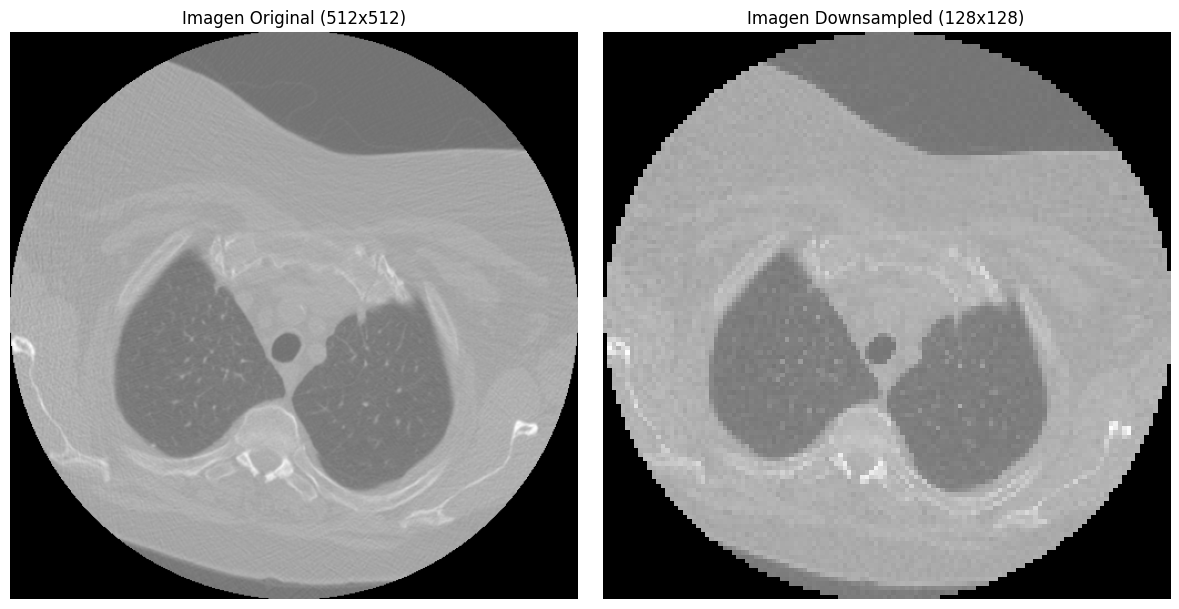


--- Comentarios sobre las diferencias (Punto 6) ---
Observa la pérdida de detalle en la imagen reducida.
Los bordes pueden parecer más 'pixelados' o 'cuadriculados' (aliasing).
La cantidad de información se reduce significativamente (1/16 de los píxeles originales).
El tamaño del archivo (si se guardara) sería menor.
(Añade tus propias observaciones detalladas en el informe .ipynb)


In [ ]:
try:
    ds_p5 = pydicom.dcmread(p5_filepath)
    img_p5_original = ds_p5.pixel_array
    print(f"Imagen p5.dcm cargada. Tamaño original: {img_p5_original.shape}")

    # Realizar downsampling conservando 1 de cada 4 píxeles
    # Se usa slicing de NumPy: array[start:stop:step]
    # [::4] toma cada 4to elemento empezando desde el índice 0
    img_p5_downsampled = img_p5_original[::4, ::4]
    print(f"Tamaño después de downsampling (1 de cada 4): {img_p5_downsampled.shape}")

    # Mostrar las imágenes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_p5_original, cmap='gray')
    axes[0].set_title(f'Imagen Original ({img_p5_original.shape[0]}x{img_p5_original.shape[1]})')
    axes[0].axis('off') # Ocultar ejes

    axes[1].imshow(img_p5_downsampled, cmap='gray')
    axes[1].set_title(f'Imagen Downsampled ({img_p5_downsampled.shape[0]}x{img_p5_downsampled.shape[1]})')
    axes[1].axis('off') # Ocultar ejes

    plt.tight_layout()
    plt.show()

    # Comentario sobre las diferencias (para añadir a tu informe)
    print("\n--- Comentarios sobre las diferencias (Punto 6) ---")
    print("Observa la pérdida de detalle en la imagen reducida.")
    print("Los bordes pueden parecer más 'pixelados' o 'cuadriculados' (aliasing).")
    print("La cantidad de información se reduce significativamente (1/16 de los píxeles originales).")
    print("El tamaño del archivo (si se guardara) sería menor.")
    print("(Añade tus propias observaciones detalladas en el informe .ipynb)")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {p5_filepath}")
except Exception as e:
    print(f"Ocurrió un error al procesar p5.dcm: {e}")


## 3.7

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, Output
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que 'volume_3d', 'depth', 'height', 'width', 'aspect_axial'
# ya están definidos y cargados de los pasos anteriores (Puntos 4/5)

# --- Implementación Punto 7 ---

# Función para transformación Gamma (Power Law)
# s = c * (r^gamma)
# Normalizamos r a [0, 1] antes de aplicar gamma, luego re-escalamos
def transform_gamma(img, gamma, c=1.0):
    img_norm = img.astype(np.float64) # Usar float para cálculos
    min_val, max_val = np.min(img_norm), np.max(img_norm)
    if max_val == min_val: # Evitar división por cero si la imagen es constante
        return img

    range_val = max_val - min_val
    img_norm = (img_norm - min_val) / range_val # Normalizar a [0, 1]

    # Aplicar gamma (asegurarse que no haya log(0) o potencias negativas invalidas)
    img_gamma = c * np.power(img_norm, gamma)

    # Re-escalar al rango original (aproximado) y convertir a tipo original si es necesario
    img_transformed = (img_gamma * range_val) + min_val
    # Asegurarse que los valores estén dentro del rango posible si es necesario (ej. uint8, uint16)
    # Para DICOM, a menudo no se necesita clipping si c=1 y gamma > 0
    # Si se usa C != 1, clipping puede ser necesario
    # img_transformed = np.clip(img_transformed, min_val, max_val)

    # Devolver en un tipo adecuado para imshow, puede ser float o int si se convierte
    return img_transformed.astype(img.dtype)


# Función para transformación Lineal por Tramos (Contrast Stretching)
# Basado en la figura 3.10(a) - 3 segmentos lineales
# Puntos (r1, s1) y (r2, s2) definen la parte central
# r son los valores de entrada, s los de salida
def transform_piecewise_linear(img, r1, s1, r2, s2):
    img_float = img.astype(np.float64)
    min_val, max_val = np.min(img_float), np.max(img_float)
    if max_val == min_val or r1 >= r2: # Imagen constante o puntos inválidos
        return img

    # Crear un array para los valores de salida
    img_transformed = np.zeros_like(img_float)

    # Asegurar que r1, s1, r2, s2 estén dentro del rango de la imagen
    # (Esto se maneja mejor con los límites de los sliders)

    # Tramos de la transformación
    # Tramo 1: [0, r1) -> [0, s1)
    mask1 = img_float < r1
    if r1 > 0: # Evitar división por cero
        img_transformed[mask1] = (s1 / r1) * img_float[mask1]

    # Tramo 2: [r1, r2] -> [s1, s2]
    mask2 = (img_float >= r1) & (img_float <= r2)
    if r2 > r1: # Evitar división por cero
         img_transformed[mask2] = ((s2 - s1) / (r2 - r1)) * (img_float[mask2] - r1) + s1

    # Tramo 3: (r2, max_val] -> (s2, max_val] (asumimos que escala hasta max_val al final)
    mask3 = img_float > r2
    if max_val > r2: # Evitar división por cero
        # Escalar para que max_val mapee a max_val (o algún otro valor S_max)
        s_max = max_val # O podrías definir otro S_max si quieres
        img_transformed[mask3] = ((s_max - s2) / (max_val - r2)) * (img_float[mask3] - r2) + s2

    # Asegurar que los valores transformados no excedan el rango original (opcional pero seguro)
    img_transformed = np.clip(img_transformed, min_val, max_val)

    return img_transformed.astype(img.dtype)

# --- Widget Interactivo ---

# Obtener rango de intensidad del volumen completo para los sliders
min_intensity = int(np.min(volume_3d))
max_intensity = int(np.max(volume_3d))
print(f"Rango de intensidad del volumen: [{min_intensity}, {max_intensity}]")

# Widget para seleccionar corte Z
slice_slider = IntSlider(min=0, max=depth-1, step=1, value=depth//2, description='Corte Z:', continuous_update=False)

# Widget para seleccionar tipo de transformación
transform_dropdown = Dropdown(options=['Original', 'Gamma', 'Lineal por Tramos'], value='Original', description='Mejora:')

# Widgets para parámetros Gamma
gamma_slider = FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Gamma (γ):', continuous_update=False, disabled=True)

# Widgets para parámetros Lineal por Tramos (r1, s1, r2, s2)
# Los rangos deben basarse en min_intensity y max_intensity
r1_slider = IntSlider(min=min_intensity, max=max_intensity, step=1, value=max_intensity // 4, description='r1:', continuous_update=False, disabled=True)
s1_slider = IntSlider(min=min_intensity, max=max_intensity, step=1, value=min_intensity, description='s1:', continuous_update=False, disabled=True) # s1 a menudo bajo
r2_slider = IntSlider(min=min_intensity, max=max_intensity, step=1, value=3 * max_intensity // 4, description='r2:', continuous_update=False, disabled=True)
s2_slider = IntSlider(min=min_intensity, max=max_intensity, step=1, value=max_intensity, description='s2:', continuous_update=False, disabled=True) # s2 a menudo alto

# Contenedores para organizar los widgets de parámetros
gamma_widgets = HBox([gamma_slider])
piecewise_widgets = VBox([
    HBox([r1_slider, s1_slider]),
    HBox([r2_slider, s2_slider])
])

# Output widget para mostrar las gráficas y comentarios
output_area = Output()

# Función para actualizar la visibilidad de los sliders de parámetros
def update_param_visibility(change):
    selected_transform = change['new']
    gamma_slider.disabled = (selected_transform != 'Gamma')
    r1_slider.disabled = (selected_transform != 'Lineal por Tramos')
    s1_slider.disabled = (selected_transform != 'Lineal por Tramos')
    r2_slider.disabled = (selected_transform != 'Lineal por Tramos')
    s2_slider.disabled = (selected_transform != 'Lineal por Tramos')
    # Forzar actualización de la gráfica cuando cambia la transformación
    update_plot(None) # Llama a update_plot para refrescar

# Observar cambios en el dropdown
transform_dropdown.observe(update_param_visibility, names='value')

# Función principal que se llama interactivamente
def update_plot(_): # El argumento es ignorado, usamos los valores actuales de los widgets
    with output_area:
        output_area.clear_output(wait=True) # Limpiar salida anterior

        slice_idx = slice_slider.value
        transform_type = transform_dropdown.value

        original_slice = volume_3d[slice_idx, :, :]
        transformed_slice = None
        title_suffix = "Original"

        # Aplicar transformación seleccionada
        if transform_type == 'Gamma':
            gamma = gamma_slider.value
            transformed_slice = transform_gamma(original_slice, gamma)
            title_suffix = f"Gamma (γ={gamma:.1f})"
        elif transform_type == 'Lineal por Tramos':
            r1, s1, r2, s2 = r1_slider.value, s1_slider.value, r2_slider.value, s2_slider.value
            # Validar r1 < r2 para evitar errores
            if r1 >= r2:
                 print(f"Advertencia: r1 ({r1}) debe ser menor que r2 ({r2}). Mostrando original.")
                 transformed_slice = original_slice # O alguna otra acción por defecto
                 title_suffix = "Lineal (r1>=r2!)"
            else:
                 transformed_slice = transform_piecewise_linear(original_slice, r1, s1, r2, s2)
                 title_suffix = f"Lineal (r1={r1},s1={s1},r2={r2},s2={s2})"
        else: # Original
            transformed_slice = original_slice # Es la misma

        # --- Visualización ---
        fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # 2 filas, 2 columnas

        # Imagen Original
        ax_img1 = axes[0, 0]
        im1 = ax_img1.imshow(original_slice, cmap='gray', aspect=aspect_axial)
        ax_img1.set_title(f'Corte Axial {slice_idx} - Original')
        ax_img1.axis('off')
        fig.colorbar(im1, ax=ax_img1, fraction=0.046, pad=0.04)

        # Histograma Original
        ax_hist1 = axes[1, 0]
        ax_hist1.hist(original_slice.ravel(), bins=100, range=(min_intensity, max_intensity), color='blue', alpha=0.7)
        ax_hist1.set_title('Histograma Original')
        ax_hist1.set_xlabel('Intensidad Píxel')
        ax_hist1.set_ylabel('Frecuencia')
        ax_hist1.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) # Notación científica si es necesario


        # Imagen Transformada
        ax_img2 = axes[0, 1]
        im2 = ax_img2.imshow(transformed_slice, cmap='gray', aspect=aspect_axial)
        ax_img2.set_title(f'Corte Axial {slice_idx} - {title_suffix}')
        ax_img2.axis('off')
        fig.colorbar(im2, ax=ax_img2, fraction=0.046, pad=0.04)


        # Histograma Transformado
        ax_hist2 = axes[1, 1]
        ax_hist2.hist(transformed_slice.ravel(), bins=100, range=(min_intensity, max_intensity), color='red', alpha=0.7)
        ax_hist2.set_title(f'Histograma {title_suffix}')
        ax_hist2.set_xlabel('Intensidad Píxel')
        ax_hist2.set_ylabel('Frecuencia')
        ax_hist2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        plt.tight_layout(rect=[0, 0.05, 1, 0.97]) # Ajustar layout y dejar espacio para título global
        fig.suptitle(f'Visualización Interactiva y Mejora de Contraste (Corte Z={slice_idx})', fontsize=14)
        plt.show()

        # Comentarios (para añadir a tu informe)
        print("\n--- Comentarios sobre Mejora de Contraste (Punto 7) ---")
        print(f"Transformación aplicada: {transform_type}")
        print("Observa cómo cambian la imagen y su histograma al variar los parámetros.")
        print("- Gamma < 1: Realza detalles en zonas oscuras (expande rangos bajos).")
        print("- Gamma > 1: Realza detalles en zonas claras (expande rangos altos).")
        print("- Lineal por tramos: Permite estirar/comprimir rangos específicos de intensidad (definidos por r1, s1, r2, s2).")
        print("¿Cuándo mejora el contraste?: Generalmente cuando el histograma resultante ocupa un rango más amplio de intensidades o cuando se separan picos de intensidad que estaban juntos.")
        print("¿Cuándo empeora?: Cuando se saturan muchas regiones (todo blanco o todo negro) o cuando se pierde detalle al comprimir demasiado ciertos rangos de intensidad.")
        print("(Añade tus propias observaciones detalladas en el informe .ipynb)")


# Conectar los sliders y dropdown a la función de actualización
interactive_controls = [slice_slider, transform_dropdown, gamma_slider, r1_slider, s1_slider, r2_slider, s2_slider]
for control in interactive_controls:
    control.observe(update_plot, names='value')

# Mostrar los widgets y el área de salida
display(VBox([
    slice_slider,
    transform_dropdown,
    gamma_widgets,
    piecewise_widgets,
    output_area
]))

# Llamar a la función una vez al inicio para mostrar la primera gráfica
update_param_visibility({'new': transform_dropdown.value}) # Para asegurar estado inicial correcto de sliders
update_plot(None)

Rango de intensidad del volumen: [-2000, 3204]


## 3.8

Slice 55: Rango [-2000, 2354], Niveles (L): 4355


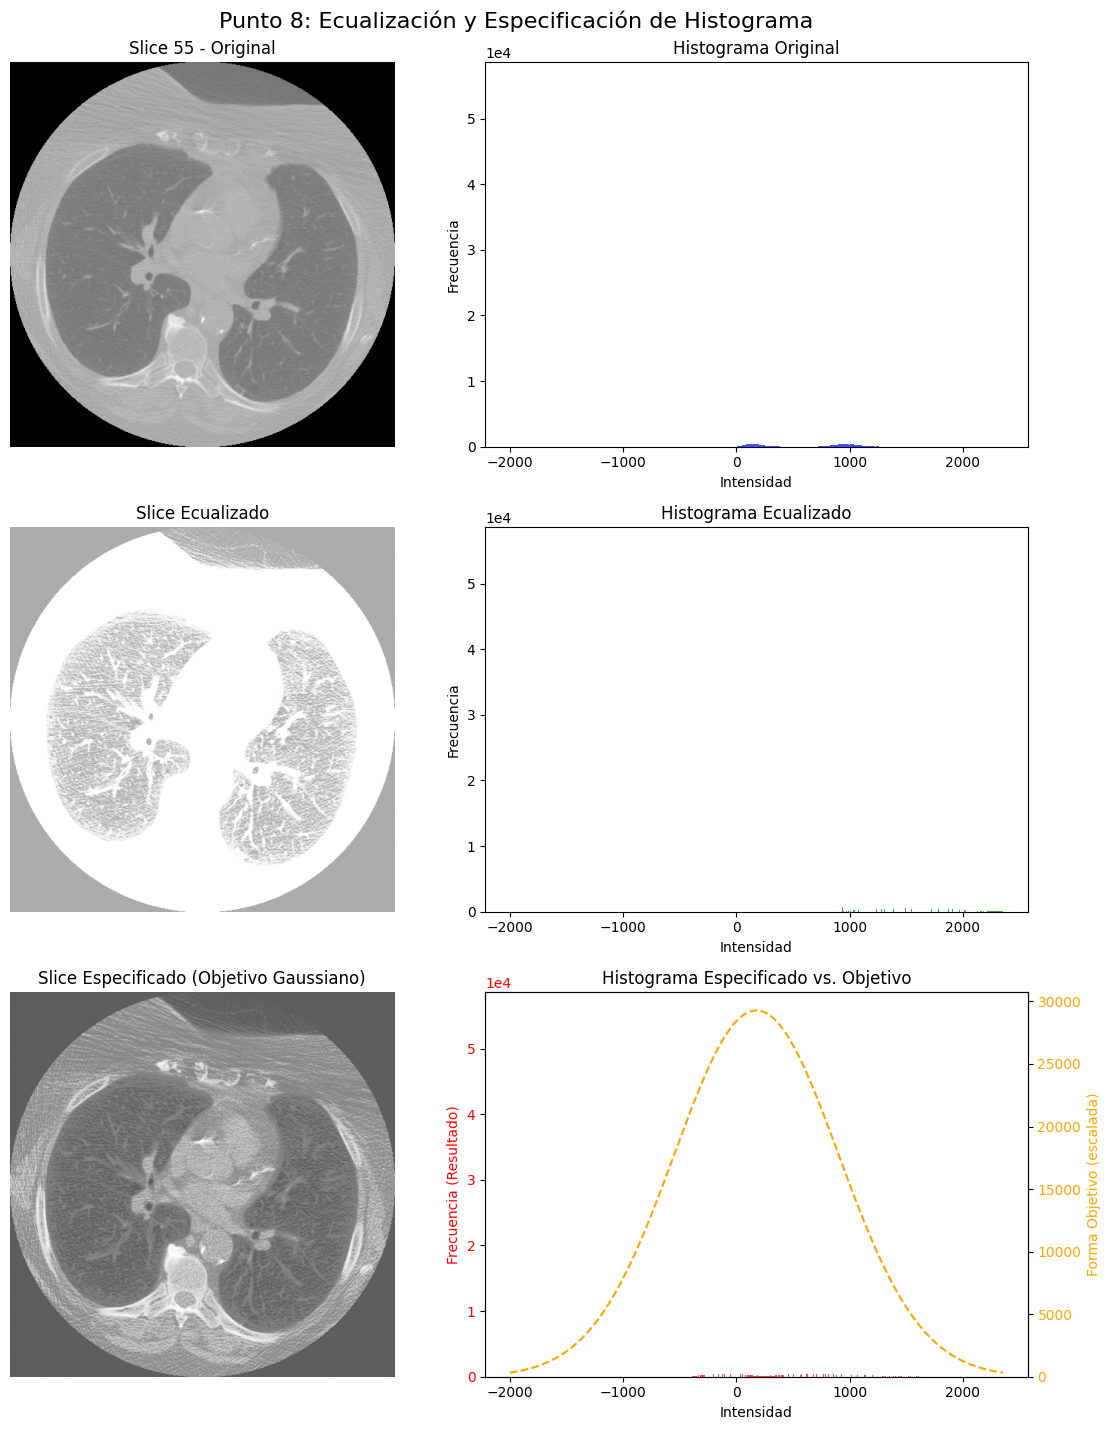


--- Explicación de Resultados (Histogramas): ---
Observa las imágenes y sus histogramas:
- Ecualización: Compara el histograma original con el ecualizado. ¿Tiende a ser más 'plano' o distribuido uniformemente? ¿Cómo afecta esto al contraste visual de la imagen (a menudo lo incrementa globalmente)?
- Especificación: Compara el histograma resultante (rojo) con la forma del histograma objetivo (naranja punteado). ¿Se parecen? ¿Cómo se ve la imagen resultante comparada con la original y la ecualizada? ¿Se realzan ciertas intensidades según la forma Gaussiana?
- Aplicabilidad: La ecualización es útil cuando se desea maximizar el contraste global sin una forma específica en mente. La especificación es útil cuando se quiere que la imagen tenga características de brillo/contraste similares a otra imagen o a una distribución conocida (útil para comparar imágenes o ajustar la apariencia).

(Escribe tus explicaciones detalladas en tu informe .ipynb)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que 'volume_3d', 'depth', 'min_intensity', 'max_intensity'
# ya están definidos y cargados de los pasos anteriores.

# --- Implementación Punto 8 ---

# 1. Seleccionar un corte representativo del volumen
# Puedes elegir uno específico o el del medio
slice_index_for_hist = depth // 2
original_slice_hist = volume_3d[slice_index_for_hist, :, :].copy() # Usar una copia

# Asegurarse de que trabajamos con enteros (común para histogramas)
# y determinar el número de niveles de gris posibles (L)
if original_slice_hist.dtype.kind in 'iu': # Si es entero (int o uint)
    # Usar el rango detectado previamente o calcularlo para el slice
    current_min = int(original_slice_hist.min())
    current_max = int(original_slice_hist.max())
    num_levels = current_max - current_min + 1
    print(f"Slice {slice_index_for_hist}: Rango [{current_min}, {current_max}], Niveles (L): {num_levels}")
    # Si el rango es muy grande, podríamos necesitar re-escalar o usar más bins,
    # pero intentaremos con el rango directo primero. Bin count = num_levels.
    hist_range = (current_min, current_max + 1) # +1 porque np.histogram es [min, max)
    bins = num_levels
else: # Si es float, hay que discretizar o elegir un número de bins
    print(f"Slice {slice_index_for_hist}: Tipo de dato float. Usando 256 bins.")
    current_min = float(original_slice_hist.min())
    current_max = float(original_slice_hist.max())
    num_levels = 256
    bins = num_levels
    hist_range = (current_min, current_max)
    # Podríamos escalar a 0-255 si fuera necesario:
    # original_slice_hist = np.interp(original_slice_hist, (current_min, current_max), (0, 255)).astype(np.uint8)
    # current_min, current_max, num_levels = 0, 255, 256
    # hist_range = (0, 256)


# --- a) Ecualización de Histograma ---

def histogram_equalization(image, num_levels, hist_range):
    """Implementa la ecualización de histograma manualmente."""
    # Calcular histograma
    hist, bin_edges = np.histogram(image.ravel(), bins=num_levels, range=hist_range)

    # Calcular CDF (Cumulative Distribution Function)
    cdf = hist.cumsum()

    # Normalizar CDF
    # Asegurarse de no dividir por cero si la imagen es constante
    total_pixels = cdf[-1]
    if total_pixels == 0:
        return image # No se puede ecualizar una imagen vacía o constante de esta manera

    cdf_normalized = cdf * (num_levels - 1) / total_pixels

    # Mapear los valores de intensidad originales a los valores ecualizados usando la CDF normalizada
    # Usamos np.interp para mapear los valores de la imagen original a través de la CDF.
    # Los bin_edges definen los centros de los bins o los límites. Necesitamos mapear valores.
    # Creamos un mapeo: valor_original -> valor_ecualizado
    # Para enteros, la CDF nos da directamente el nuevo valor para cada bin original.

    # Si la imagen es de enteros, podemos crear una Look-Up Table (LUT)
    if image.dtype.kind in 'iu':
        # Asegurar que los índices no se salgan del rango de cdf_normalized
        min_val = int(hist_range[0])
        # Necesitamos mapear cada valor posible de pixel en la imagen
        # Creamos un array de todos los valores posibles en el rango
        possible_values = np.arange(min_val, int(hist_range[1]))
        # Mapeamos estos valores usando la CDF. np.interp necesita x y xp ordenados.
        # xp son los valores originales (centros de bin o bordes), fp es la CDF normalizada
        # Aquí, la forma más simple es usar la CDF directamente como LUT para los valores enteros
        # mapeando el valor del pixel 'p' al valor redondeado de cdf_normalized[p - min_val]

        equalized_image_flat = np.interp(image.ravel(), bin_edges[:-1], cdf_normalized)

        # Alternativa con LUT si los valores son manejables (ej. 0-255)
        # lut = np.round(cdf_normalized).astype(image.dtype)
        # equalized_image_flat = lut[image.ravel() - min_val]

        equalized_image = equalized_image_flat.reshape(image.shape).astype(image.dtype)

    else: # Si es float, la interpolación es más directa
         equalized_image_flat = np.interp(image.ravel(), bin_edges[:-1], cdf_normalized)
         equalized_image = equalized_image_flat.reshape(image.shape).astype(image.dtype)

    return equalized_image

# Aplicar ecualización
equalized_slice = histogram_equalization(original_slice_hist, bins, hist_range)


# --- b) Especificación de Histograma ---

def histogram_specification(image, target_hist_pdf, num_levels, hist_range):
    """Implementa especificación de histograma manualmente."""
    # 1. Calcular CDF de la imagen original (T(r))
    hist_image, bin_edges_image = np.histogram(image.ravel(), bins=num_levels, range=hist_range)
    cdf_image = hist_image.cumsum()
    total_pixels_image = cdf_image[-1]
    if total_pixels_image == 0: return image
    cdf_image_normalized = cdf_image / total_pixels_image # T(r) normalizada [0, 1]

    # 2. Calcular CDF del histograma objetivo (G(z))
    # Asegurar que target_hist_pdf tenga la longitud correcta (num_levels) y sume 1 (o normalizarla)
    target_hist_pdf_norm = target_hist_pdf / target_hist_pdf.sum()
    cdf_target = target_hist_pdf_norm.cumsum() # G(z) normalizada [0, 1]

    # 3. Mapeo inverso G^-1(T(r))
    # Para cada valor posible 'r' de la imagen original:
    #   a. Calcular su CDF normalizada: t = cdf_image_normalized[r - min_val]
    #   b. Encontrar el valor 'z' tal que cdf_target[z - min_val] sea lo más cercano a 't'.

    specified_mapping = np.zeros(num_levels, dtype=np.int_)
    for r_idx in range(num_levels):
        t = cdf_image_normalized[r_idx]
        # Encontrar el índice z_idx que minimiza |cdf_target[z_idx] - t|
        z_idx = np.argmin(np.abs(cdf_target - t))
        specified_mapping[r_idx] = z_idx

    # Ajustar mapeo si los rangos no empiezan en 0
    min_val = int(hist_range[0])
    specified_mapping += min_val # Ajustar al rango de salida deseado

    # 4. Aplicar el mapeo a la imagen original
    if image.dtype.kind in 'iu':
        # Crear LUT a partir del mapeo
        specified_image_flat = specified_mapping[image.ravel() - min_val]
        specified_image = specified_image_flat.reshape(image.shape).astype(image.dtype)
    else: # Para float, interpolar usando el mapeo podría ser más robusto
        # O aplicar el mapeo a valores discretizados si se hizo antes
        # Aquí asumimos que podemos aplicar el mapeo discreto directamente si es float
        # Esto puede requerir ajustar la lógica o discretizar la imagen float primero

        # Opción simple (puede no ser ideal para float): aplicar mapeo a valores redondeados/discretos
        print("Advertencia: Aplicando mapeo discreto a imagen float. Considera discretizar primero.")
        image_indices = np.interp(image.ravel(), bin_edges_image[:-1], np.arange(num_levels)).astype(int)
        specified_image_flat = specified_mapping[image_indices]
        specified_image = specified_image_flat.reshape(image.shape).astype(image.dtype)


    return specified_image

# Crear un histograma objetivo (ej. Gaussiano centrado en el medio del rango)
mean_target = (current_max + current_min) / 2
std_dev_target = (current_max - current_min) / 6 # Desviación estándar (ajustable)
target_levels = np.arange(current_min, hist_range[1]) # Niveles posibles

# Fórmula PDF Gaussiana (no normalizada)
target_hist_pdf = np.exp(-((target_levels - mean_target)**2) / (2 * std_dev_target**2))
# Asegurar que tenga la longitud correcta (igual a bins)
if len(target_hist_pdf) != bins:
     # Si el rango no coincide exactamente con 'bins' (ej. float), ajustamos
     target_levels_for_pdf = np.linspace(hist_range[0], hist_range[1], bins, endpoint=False)
     target_hist_pdf = np.exp(-((target_levels_for_pdf - mean_target)**2) / (2 * std_dev_target**2))

# Aplicar especificación
specified_slice = histogram_specification(original_slice_hist, target_hist_pdf, bins, hist_range)


# --- c) Visualización y Explicación ---

fig, axes = plt.subplots(3, 2, figsize=(12, 15)) # 3 filas (Original, Eq, Spec), 2 cols (Img, Hist)

# Original
axes[0, 0].imshow(original_slice_hist, cmap='gray', vmin=current_min, vmax=current_max)
axes[0, 0].set_title(f'Slice {slice_index_for_hist} - Original')
axes[0, 0].axis('off')
axes[0, 1].hist(original_slice_hist.ravel(), bins=bins, range=hist_range, color='blue', alpha=0.7)
axes[0, 1].set_title('Histograma Original')
axes[0, 1].set_xlabel('Intensidad')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))


# Ecualizada
axes[1, 0].imshow(equalized_slice, cmap='gray', vmin=current_min, vmax=current_max)
axes[1, 0].set_title('Slice Ecualizado')
axes[1, 0].axis('off')
axes[1, 1].hist(equalized_slice.ravel(), bins=bins, range=hist_range, color='green', alpha=0.7)
axes[1, 1].set_title('Histograma Ecualizado')
axes[1, 1].set_xlabel('Intensidad')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))


# Especificada
axes[2, 0].imshow(specified_slice, cmap='gray', vmin=current_min, vmax=current_max)
axes[2, 0].set_title(f'Slice Especificado (Objetivo Gaussiano)')
axes[2, 0].axis('off')
ax_spec_hist = axes[2, 1]
ax_spec_hist.hist(specified_slice.ravel(), bins=bins, range=hist_range, color='red', alpha=0.7, label='Resultado Especificado')
# Superponer el histograma objetivo (escalado) para comparación
ax_spec_hist_target = ax_spec_hist.twinx() # Eje Y secundario para el objetivo
target_hist_pdf_scaled = target_hist_pdf * (ax_spec_hist.get_ylim()[1] / target_hist_pdf.max() * 0.5) # Escalar para visualización
ax_spec_hist_target.plot(target_levels, target_hist_pdf_scaled, color='orange', linestyle='--', label=f'Objetivo Gaussiano (μ={mean_target:.0f}, σ={std_dev_target:.0f})')
ax_spec_hist_target.set_ylabel('Forma Objetivo (escalada)', color='orange')
ax_spec_hist_target.tick_params(axis='y', labelcolor='orange')
ax_spec_hist_target.set_ylim(bottom=0)

ax_spec_hist.set_title('Histograma Especificado vs. Objetivo')
ax_spec_hist.set_xlabel('Intensidad')
ax_spec_hist.set_ylabel('Frecuencia (Resultado)', color='red')
ax_spec_hist.tick_params(axis='y', labelcolor='red')
ax_spec_hist.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# Combinar leyendas si es necesario o simplemente mostrarlas
lines, labels = ax_spec_hist.get_legend_handles_labels()
lines2, labels2 = ax_spec_hist_target.get_legend_handles_labels()
#ax_spec_hist_target.legend(lines + lines2, labels + labels2, loc=0) # Puede quedar desordenado


plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Ajustar layout
fig.suptitle('Punto 8: Ecualización y Especificación de Histograma', fontsize=16)
plt.show()

# Explicación de los resultados (para añadir a tu informe)
print("\n--- Explicación de Resultados (Histogramas): ---")
print("="*30)
print("Observa las imágenes y sus histogramas:")
print("- Ecualización: Compara el histograma original con el ecualizado. ¿Tiende a ser más 'plano' o distribuido uniformemente? ¿Cómo afecta esto al contraste visual de la imagen (a menudo lo incrementa globalmente)?")
print("- Especificación: Compara el histograma resultante (rojo) con la forma del histograma objetivo (naranja punteado). ¿Se parecen? ¿Cómo se ve la imagen resultante comparada con la original y la ecualizada? ¿Se realzan ciertas intensidades según la forma Gaussiana?")
print("- Aplicabilidad: La ecualización es útil cuando se desea maximizar el contraste global sin una forma específica en mente. La especificación es útil cuando se quiere que la imagen tenga características de brillo/contraste similares a otra imagen o a una distribución conocida (útil para comparar imágenes o ajustar la apariencia).")
print("\n(Escribe tus explicaciones detalladas en tu informe .ipynb)")

In [ ]:
from scipy.ndimage import convolve as scipy_convolve # Para comparación en Punto 1

# Asumimos que 'volume_3d' y sus dimensiones están cargadas de pasos anteriores.
# Seleccionamos un slice para aplicar los filtros 2D (puedes cambiarlo)
slice_index_filt = depth // 2
image_to_filter = volume_3d[slice_index_filt, :, :].astype(np.float64) # Usar float para filtros

# Definir ruta para xray.dcm (ajústala si es necesario)
xray_filepath = './Tarea_1/datos/xray.dcm'

print(f"Se usará el slice {slice_index_filt} de data_2 para el Punto 3.2.1 y 3.2.3.")
print(f"Se usará {xray_filepath} para el Punto 3.2.2.")

Se usará el slice 55 de data_2 para el Punto 3.2.1 y 3.2.3.
Se usará ./Tarea_1/datos/xray.dcm para el Punto 3.2.2.



Aplicando filtros manualmente...
Comparando con scipy.ndimage.convolve (Filtro Gaussiano)...
Diferencia Máxima Absoluta entre convolución manual y scipy: 1.1368683772161603e-12
Diferencia Media Absoluta: 1.0402873851109379e-13


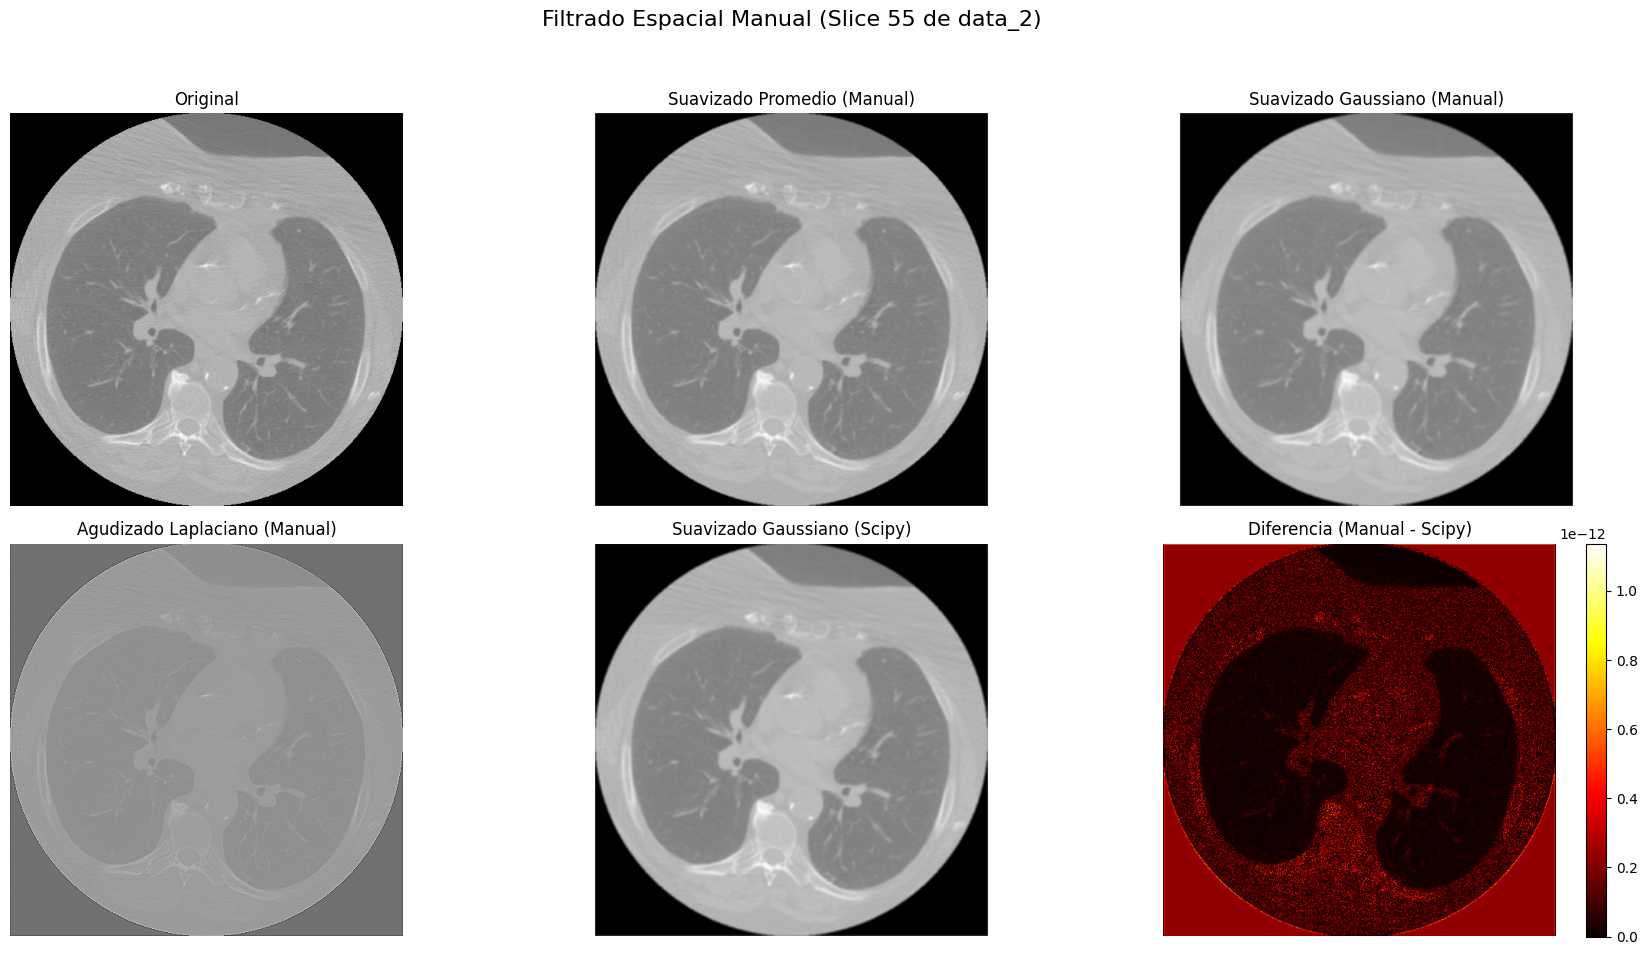

In [ ]:
# --- Implementación Convolución Manual (Punto 3.2.1) ---
def convolve2d_manual(image, kernel):
    """
    Realiza convolución 2D manual entre una imagen y un kernel.
    Asume que el kernel tiene dimensiones impares.
    Utiliza padding con ceros.
    """
    # Obtener dimensiones
    k_height, k_width = kernel.shape
    img_height, img_width = image.shape

    # Calcular padding (usando la fórmula de ayuda)
    pad_h = (k_height - 1) // 2
    pad_w = (k_width - 1) // 2

    # Aplicar padding a la imagen
    image_padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    # Crear imagen de salida
    output = np.zeros_like(image)

    # Voltear el kernel (esencial para la definición matemática de convolución)
    kernel_flipped = np.flipud(np.fliplr(kernel))

    # Realizar la convolución
    for y in range(img_height):
        for x in range(img_width):
            # Extraer la región de la imagen padded correspondiente al kernel
            region = image_padded[y : y + k_height, x : x + k_width]
            # Calcular el producto punto entre la región y el kernel volteado
            output[y, x] = np.sum(region * kernel_flipped)

    return output

# --- Implementación Generador Kernel Gaussiano (Punto 3.2.1) ---
def gaussian_kernel(size, sigma=1.0):
    """Genera un kernel Gaussiano 2D."""
    if size % 2 == 0:
        raise ValueError("El tamaño del kernel debe ser impar")

    center = size // 2
    kernel = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalizar el kernel para que sume 1 (importante para blurring)
    return kernel / kernel.sum()

# --- Definición de Kernels (Punto 3.2.1) ---
# Suavizado - Promedio 3x3
avg_kernel_3x3 = np.ones((3, 3), dtype=np.float64) / 9.0

# Suavizado - Gaussiano 5x5
gauss_kernel_5x5 = gaussian_kernel(size=5, sigma=1.5)

# Agudizado - Laplaciano (una versión común)
# [[0, -1, 0], [-1, 4, -1], [0, -1, 0]] -> Resultado se resta de la original
# O [[0, 1, 0], [1, -4, 1], [0, 1, 0]] -> Resultado se suma (si se quiere f + c*nabla^2 f)
# O [[-1,-1,-1], [-1, 8,-1], [-1,-1,-1]] -> Resultado se suma
# Usaremos la segunda versión para calcular laplaciano_img = convolve(img, kernel)
# y luego sharpened = img - laplaciano_img (o img + c*laplaciano_img con kernel opuesto)
laplacian_kernel = np.array([[0, 1, 0],
                             [1,-4, 1],
                             [0, 1, 0]], dtype=np.float64)

# --- Aplicar Filtros Manualmente (Punto 3.2.1) ---
print("\nAplicando filtros manualmente...")
blurred_avg_manual = convolve2d_manual(image_to_filter, avg_kernel_3x3)
blurred_gauss_manual = convolve2d_manual(image_to_filter, gauss_kernel_5x5)
laplacian_result_manual = convolve2d_manual(image_to_filter, laplacian_kernel)
# Imagen agudizada = Original - Laplaciano (o con otra variante)
sharpened_laplacian_manual = image_to_filter - laplacian_result_manual

# --- Comparación con Scipy (para filtro Gaussiano) (Punto 3.2.1) ---
print("Comparando con scipy.ndimage.convolve (Filtro Gaussiano)...")
# NOTA: scipy.ndimage.convolve realiza la convolución (voltea el kernel)
#       scipy.ndimage.correlate NO voltea el kernel
blurred_gauss_scipy = scipy_convolve(image_to_filter, gauss_kernel_5x5, mode='constant', cval=0.0)

# Calcular diferencia
difference = np.abs(blurred_gauss_manual - blurred_gauss_scipy)
print(f"Diferencia Máxima Absoluta entre convolución manual y scipy: {np.max(difference)}")
print(f"Diferencia Media Absoluta: {np.mean(difference)}")
# Pequeñas diferencias son esperables debido a la precisión numérica de float.

# --- Visualización Resultados (Punto 3.2.1) ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Filtrado Espacial Manual (Slice {slice_index_filt} de data_2)', fontsize=16)

# Fila 1
axes[0, 0].imshow(image_to_filter, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(blurred_avg_manual, cmap='gray')
axes[0, 1].set_title('Suavizado Promedio (Manual)')
axes[0, 1].axis('off')

axes[0, 2].imshow(blurred_gauss_manual, cmap='gray')
axes[0, 2].set_title('Suavizado Gaussiano (Manual)')
axes[0, 2].axis('off')

# Fila 2
axes[1, 0].imshow(sharpened_laplacian_manual, cmap='gray')
axes[1, 0].set_title('Agudizado Laplaciano (Manual)')
axes[1, 0].axis('off')

axes[1, 1].imshow(blurred_gauss_scipy, cmap='gray')
axes[1, 1].set_title('Suavizado Gaussiano (Scipy)')
axes[1, 1].axis('off')

axes[1, 2].imshow(difference, cmap='hot')
axes[1, 2].set_title('Diferencia (Manual - Scipy)')
axes[1, 2].axis('off')
fig.colorbar(axes[1, 2].imshow(difference, cmap='hot'), ax=axes[1, 2])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Imagen ./Tarea_1/datos/xray.dcm cargada. Tamaño: (1024, 1024)


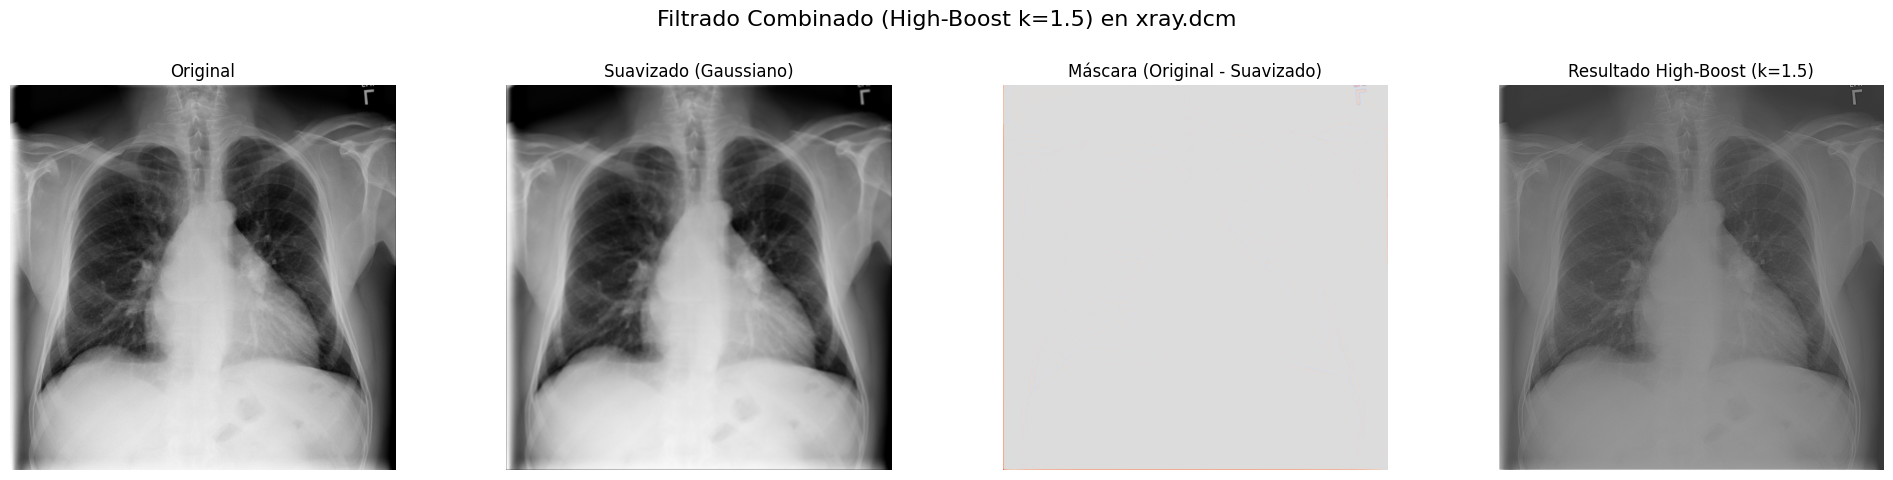


--- Explicación de Pertinencia (Punto 3.2.2): ---
Pasos aplicados a xray.dcm con k=1.5:
1. Suavizado Gaussiano: Reduce el ruido y detalles de baja frecuencia.
2. Creación de Máscara (Original - Suavizado): Aísla los detalles de alta frecuencia (bordes, texturas finas) que fueron eliminados por el suavizado.
3. Suma Ponderada (Original + k * Máscara): Añade los detalles aislados (la máscara) de vuelta a la imagen original, ponderados por 'k'.
   - Si k=1 (Unsharp Masking): Restaura los detalles perdidos, agudizando la imagen.
   - Si k>1 (High-Boost, como aquí con k=1.5): Amplifica los detalles, resultando en una imagen aún más nítida (a veces puede introducir artefactos o ruido si k es muy alto).
Pertinencia: Esta técnica es útil para realzar bordes y detalles finos en imágenes médicas como rayos X, mejorando la visibilidad de estructuras anatómicas.
(Añade tus propias observaciones sobre el resultado visual en el informe .ipynb)


In [ ]:
# --- Cargar imagen xray.dcm (Punto 3.2.2) ---
try:
    ds_xray = pydicom.dcmread(xray_filepath)
    xray_image = ds_xray.pixel_array.astype(np.float64)
    print(f"\nImagen {xray_filepath} cargada. Tamaño: {xray_image.shape}")

    # --- Aplicar Filtrado Combinado (Unsharp Masking / High-Boost) ---
    # Paso 1: Suavizar la imagen original (usando un kernel Gaussiano)
    #         Puedes ajustar el tamaño y sigma del kernel Gaussiano
    blur_kernel_xray = gaussian_kernel(size=7, sigma=2.0)
    blurred_xray = convolve2d_manual(xray_image, blur_kernel_xray)

    # Paso 2: Calcular la máscara (Original - Suavizado)
    mask_xray = xray_image - blurred_xray

    # Paso 3: Añadir una fracción de la máscara a la original (High-Boost)
    k = 1.5 # Factor de Boost (k=1 es Unsharp Masking, k>1 es High-Boost)
    sharpened_boosted_xray = xray_image + k * mask_xray

    # --- Visualización Resultados (Punto 3.2.2) ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Filtrado Combinado (High-Boost k={k}) en {os.path.basename(xray_filepath)}', fontsize=16)

    axes[0].imshow(xray_image, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(blurred_xray, cmap='gray')
    axes[1].set_title('Suavizado (Gaussiano)')
    axes[1].axis('off')

    # Mostrar máscara con un colormap divergente puede ser útil
    axes[2].imshow(mask_xray, cmap='coolwarm', vmin=-abs(mask_xray).max(), vmax=abs(mask_xray).max())
    axes[2].set_title('Máscara (Original - Suavizado)')
    axes[2].axis('off')

    axes[3].imshow(sharpened_boosted_xray, cmap='gray')
    axes[3].set_title(f'Resultado High-Boost (k={k})')
    axes[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

    # Explicación de la pertinencia (para tu informe)
    print("\n--- Explicación de Pertinencia (Punto 3.2.2): ---")
    print(f"Pasos aplicados a {os.path.basename(xray_filepath)} con k={k}:")
    print("1. Suavizado Gaussiano: Reduce el ruido y detalles de baja frecuencia.")
    print("2. Creación de Máscara (Original - Suavizado): Aísla los detalles de alta frecuencia (bordes, texturas finas) que fueron eliminados por el suavizado.")
    print(f"3. Suma Ponderada (Original + k * Máscara): Añade los detalles aislados (la máscara) de vuelta a la imagen original, ponderados por 'k'.")
    print("   - Si k=1 (Unsharp Masking): Restaura los detalles perdidos, agudizando la imagen.")
    print(f"   - Si k>1 (High-Boost, como aquí con k={k}): Amplifica los detalles, resultando en una imagen aún más nítida (a veces puede introducir artefactos o ruido si k es muy alto).")
    print("Pertinencia: Esta técnica es útil para realzar bordes y detalles finos en imágenes médicas como rayos X, mejorando la visibilidad de estructuras anatómicas.")
    print("(Añade tus propias observaciones sobre el resultado visual en el informe .ipynb)")


except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {xray_filepath}")
except Exception as e:
    print(f"Ocurrió un error al procesar {xray_filepath}: {e}")



--- Resultados SNR (Punto 3.2.3) ---
ROI seleccionada: Y=[100:150], X=[200:250]
Imagen Original:
  - Media (μ): 494.6320
  - Desv. Estándar (σ): 374.5899
  - SNR (μ/σ): 1.3205

Imagen Suavizada (Gaussiana Manual):
  - Media (μ): 494.7542
  - Desv. Estándar (σ): 365.7363
  - SNR (μ/σ): 1.3528

Discusión:
El filtro de suavizado incrementó la SNR (de 1.3205 a 1.3528).
Esto es esperado en regiones homogéneas, ya que el suavizado reduce la variación (ruido, σ) mientras idealmente mantiene la señal promedio (μ) relativamente constante.
(Asegúrate de elegir una ROI adecuada y explica tus resultados específicos en el informe).


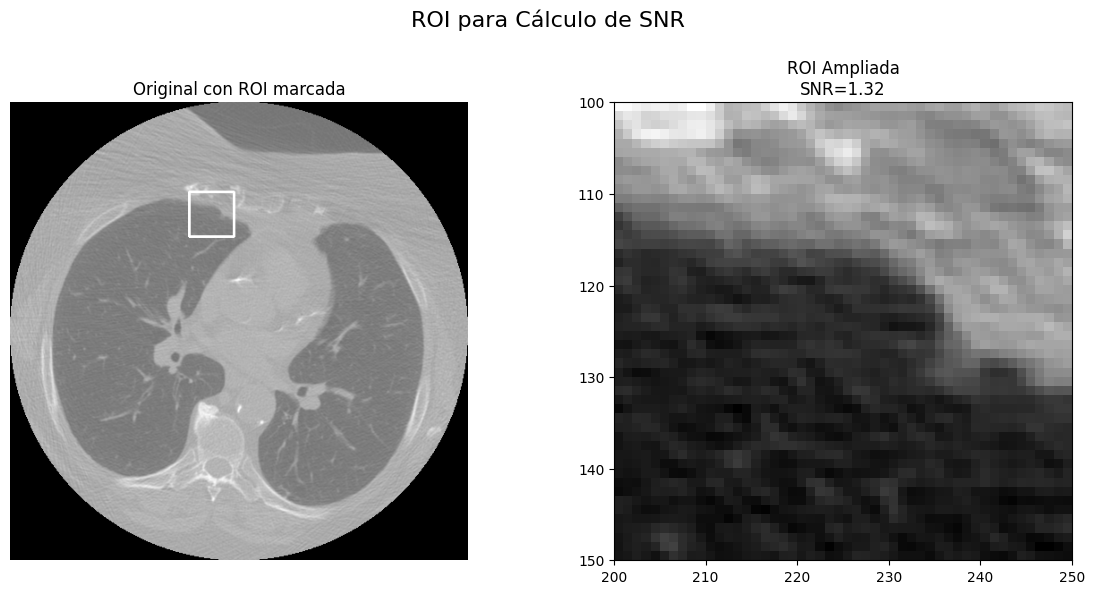

In [ ]:
# --- Selección Manual de ROI (Punto 3.2.3) ---
# ¡IMPORTANTE! Debes ajustar estas coordenadas (y1, y2, x1, x2)
# inspeccionando 'image_to_filter' (el slice de CT) para encontrar
# una región que parezca relativamente homogénea (sin bordes fuertes, textura uniforme).
import cv2
# Ejemplo de coordenadas (ajústalas):
roi_y1, roi_y2 = 100, 150 # Rango de filas (eje Y)
roi_x1, roi_x2 = 200, 250 # Rango de columnas (eje X)

# Verificar que las coordenadas estén dentro de los límites de la imagen
img_h, img_w = image_to_filter.shape
roi_y1 = max(0, roi_y1)
roi_y2 = min(img_h, roi_y2)
roi_x1 = max(0, roi_x1)
roi_x2 = min(img_w, roi_x2)

if roi_y1 >= roi_y2 or roi_x1 >= roi_x2:
    print("Error: Coordenadas de ROI inválidas o resultan en un área vacía.")
else:
    # Extraer la ROI de la imagen original y la suavizada
    roi_original = image_to_filter[roi_y1:roi_y2, roi_x1:roi_x2]
    # Usar la imagen suavizada Gaussiana del punto 1
    roi_smoothed = blurred_gauss_manual[roi_y1:roi_y2, roi_x1:roi_x2]

    # --- Cálculo de SNR ---
    def calculate_snr(roi):
        """Calcula SNR = mu / sigma para una ROI."""
        mu = np.mean(roi)
        sigma = np.std(roi)
        if sigma == 0: # Evitar división por cero
            return np.inf if mu != 0 else 0 # SNR infinita si no hay ruido (ideal) o 0 si todo es 0
        return mu / sigma

    snr_original = calculate_snr(roi_original)
    snr_smoothed = calculate_snr(roi_smoothed)

    print(f"\n--- Resultados SNR (Punto 3.2.3) ---")
    print(f"ROI seleccionada: Y=[{roi_y1}:{roi_y2}], X=[{roi_x1}:{roi_x2}]")
    print(f"Imagen Original:")
    print(f"  - Media (μ): {np.mean(roi_original):.4f}")
    print(f"  - Desv. Estándar (σ): {np.std(roi_original):.4f}")
    print(f"  - SNR (μ/σ): {snr_original:.4f}")
    print(f"\nImagen Suavizada (Gaussiana Manual):")
    print(f"  - Media (μ): {np.mean(roi_smoothed):.4f}")
    print(f"  - Desv. Estándar (σ): {np.std(roi_smoothed):.4f}")
    print(f"  - SNR (μ/σ): {snr_smoothed:.4f}")

    # --- Discusión ---
    print("\nDiscusión:")
    if snr_smoothed > snr_original:
        print(f"El filtro de suavizado incrementó la SNR (de {snr_original:.4f} a {snr_smoothed:.4f}).")
        print("Esto es esperado en regiones homogéneas, ya que el suavizado reduce la variación (ruido, σ) mientras idealmente mantiene la señal promedio (μ) relativamente constante.")
    elif snr_smoothed < snr_original:
         print(f"El filtro de suavizado disminuyó la SNR (de {snr_original:.4f} a {snr_smoothed:.4f}).")
         print("Esto podría ocurrir si la ROI no era suficientemente homogénea y el suavizado afectó la señal promedio (μ) o si el ruido no fue el factor dominante en la desviación estándar original.")
    else:
        print("La SNR no cambió significativamente.")

    print("(Asegúrate de elegir una ROI adecuada y explica tus resultados específicos en el informe).")

    # --- Visualización de la ROI (Opcional pero útil) ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('ROI para Cálculo de SNR', fontsize=16)

    img_with_roi_original = image_to_filter.copy()
    cv2.rectangle(img_with_roi_original, (roi_x1, roi_y1), (roi_x2, roi_y2), (image_to_filter.max()), 2) # Dibujar rectángulo (requiere OpenCV o hacerlo manualmente)
    # Alternativa manual para dibujar rectángulo:
    img_with_roi_original[roi_y1:roi_y2, roi_x1] = image_to_filter.max() # Izquierda
    img_with_roi_original[roi_y1:roi_y2, roi_x2-1] = image_to_filter.max() # Derecha
    img_with_roi_original[roi_y1, roi_x1:roi_x2] = image_to_filter.max() # Arriba
    img_with_roi_original[roi_y2-1, roi_x1:roi_x2] = image_to_filter.max() # Abajo


    axes[0].imshow(img_with_roi_original, cmap='gray')
    axes[0].set_title('Original con ROI marcada')
    axes[0].axis('off')

    axes[1].imshow(roi_original, cmap='gray', extent=[roi_x1, roi_x2, roi_y2, roi_y1]) # Mostrar ROI ampliada
    axes[1].set_title(f'ROI Ampliada\nSNR={snr_original:.2f}')
    # axes[1].axis('off') # Puedes quitar los ejes si prefieres

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Anatómica cargada: ./Tarea_1/datos/anat.nii, Dimensiones: (41, 48, 40)
Z-map Voz cargada: ./Tarea_1/datos/zmap_voice.nii, Dimensiones: (41, 48, 40)
Z-map No-Voz cargada: ./Tarea_1/datos/zmap_nonvoice.nii, Dimensiones: (41, 48, 40)
Rango Z-score para visualización: [0.01, 0.10] (positivo) y [-0.10, -0.01] (negativo)
Mostrando 30 cortes axiales índices: [ 0  1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 26 28 29 30
 32 33 34 36 37 39]


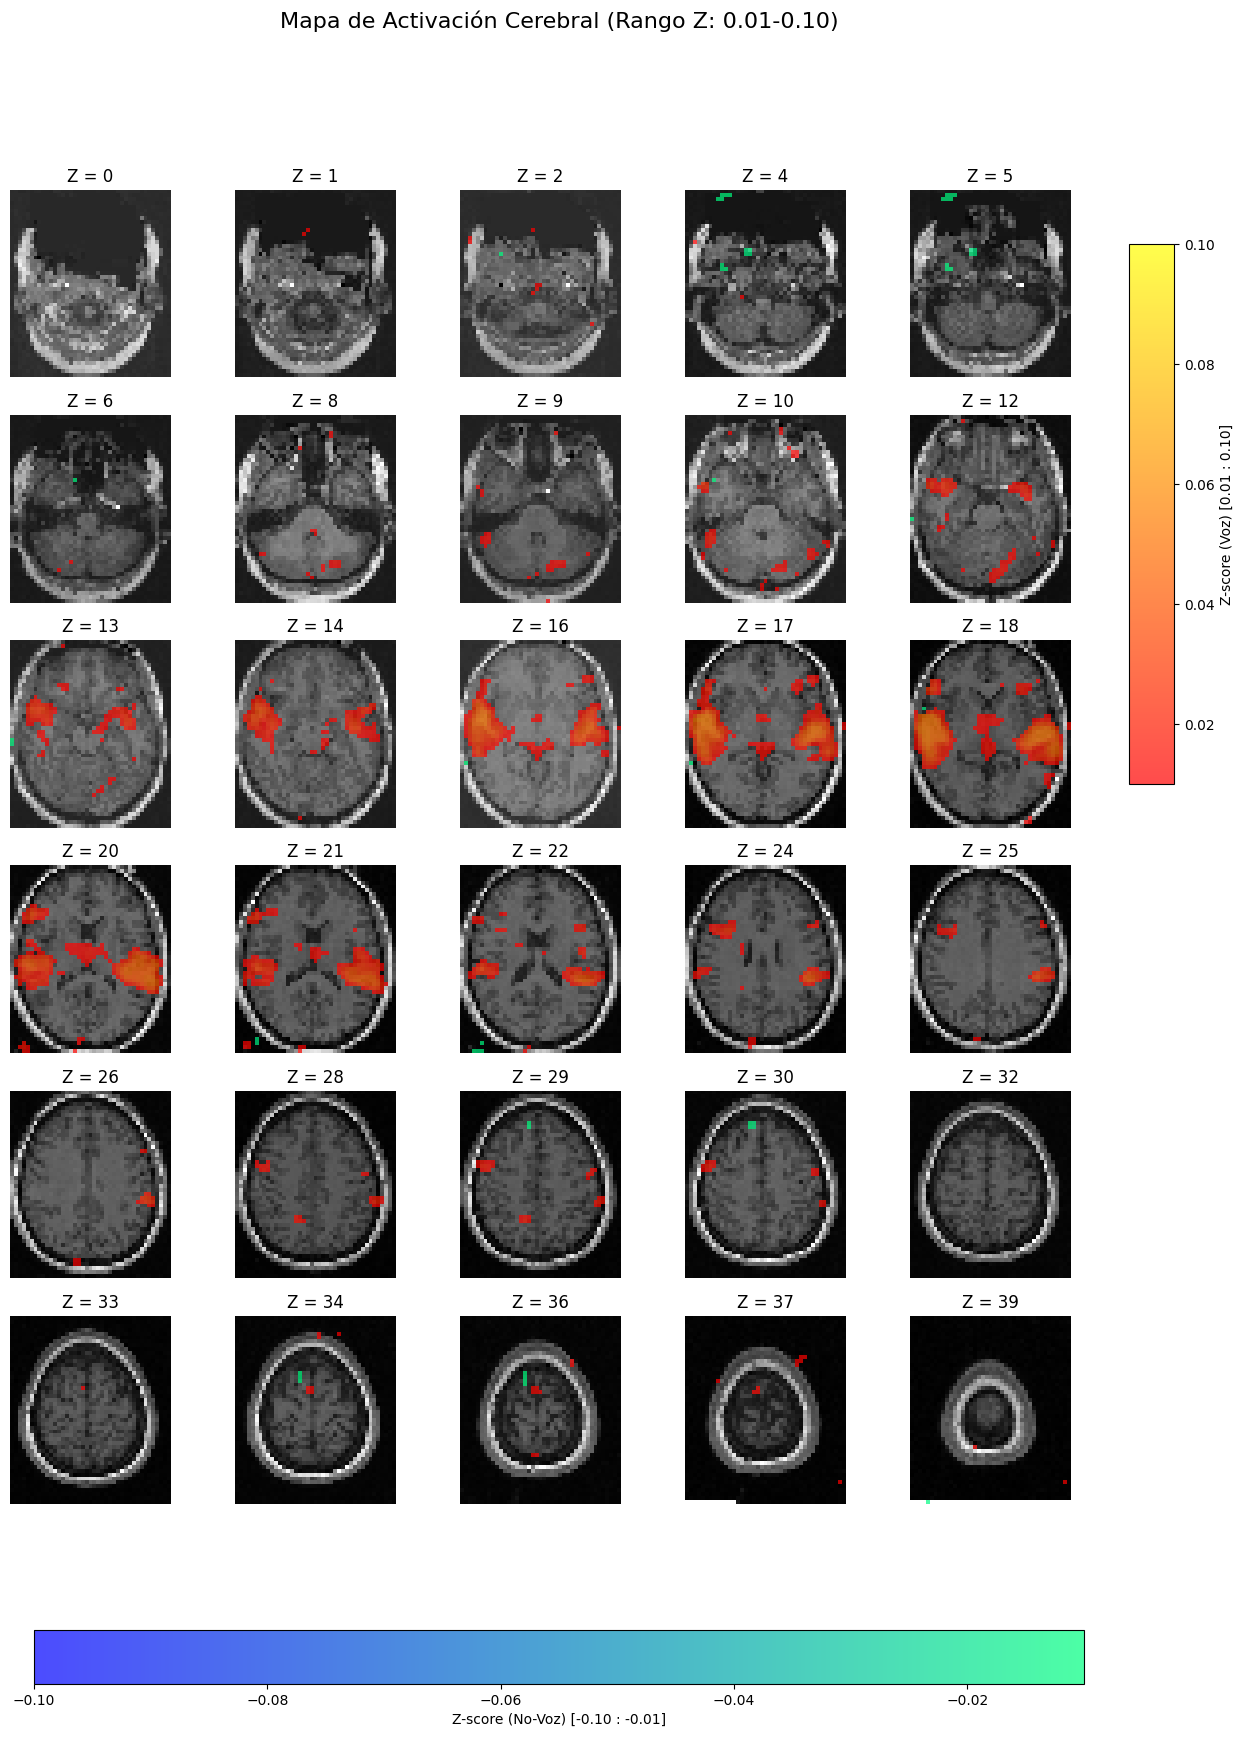

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os

# --- Configuración de Archivos y Parámetros (Punto 3.3 - UMBRAL MODIFICADO) ---

# Define las rutas a los archivos NIfTI (ajústalas si es necesario)
nii_dir = './Tarea_1/datos/' # Directorio donde están los archivos .nii
anat_path = os.path.join(nii_dir, 'anat.nii')
zmap_voice_path = os.path.join(nii_dir, 'zmap_voice.nii')
zmap_nonvoice_path = os.path.join(nii_dir, 'zmap_nonvoice.nii')

# Parámetros de visualización (UMBRAL MODIFICADO)
num_slices_to_show = 30 # Número de cortes axiales a mostrar
threshold_z_min = 0.01  # Umbral INFERIOR para los Z-scores
threshold_z_max = 0.1  # Umbral SUPERIOR para los Z-scores
cmap_anat = 'gray'      # Colormap para la imagen anatómica
cmap_voice = 'autumn'   # Colormap para activación positiva (voz)
cmap_nonvoice = 'winter' # Colormap para activación negativa (no-voz)

# --- Cargar Datos NIfTI ---
try:
    # Cargar imagen anatómica
    anat_img = nib.load(anat_path)
    anat_data = anat_img.get_fdata()
    print(f"Anatómica cargada: {anat_path}, Dimensiones: {anat_data.shape}")

    # Cargar Z-map de voz
    zmap_voice_img = nib.load(zmap_voice_path)
    zmap_voice_data = zmap_voice_img.get_fdata()
    if zmap_voice_data.shape != anat_data.shape:
        print(f"Advertencia: Dimensiones de zmap_voice {zmap_voice_data.shape} no coinciden con anatómica {anat_data.shape}")
    print(f"Z-map Voz cargada: {zmap_voice_path}, Dimensiones: {zmap_voice_data.shape}")

    # Cargar Z-map de no-voz
    zmap_nonvoice_img = nib.load(zmap_nonvoice_path)
    zmap_nonvoice_data = zmap_nonvoice_img.get_fdata()
    if zmap_nonvoice_data.shape != anat_data.shape:
         print(f"Advertencia: Dimensiones de zmap_nonvoice {zmap_nonvoice_data.shape} no coinciden con anatómica {anat_data.shape}")
    print(f"Z-map No-Voz cargada: {zmap_nonvoice_path}, Dimensiones: {zmap_nonvoice_data.shape}")

    # --- Preparar Datos para Visualización (LÓGICA DE UMBRAL MODIFICADA) ---

    print(f"Rango Z-score para visualización: [{threshold_z_min:.2f}, {threshold_z_max:.2f}] (positivo) y [{-threshold_z_max:.2f}, {-threshold_z_min:.2f}] (negativo)")

    # Crear máscaras booleanas basadas en el RANGO de umbral
    mask_voice = (zmap_voice_data >= threshold_z_min) & (zmap_voice_data <= threshold_z_max)
    mask_nonvoice = (zmap_nonvoice_data <= -threshold_z_min) & (zmap_nonvoice_data >= -threshold_z_max) # Rango negativo

    # Aplicar máscaras a los datos Z para visualización (poner NaN donde no está en el rango)
    zmap_voice_masked = np.where(mask_voice, zmap_voice_data, np.nan)
    zmap_nonvoice_masked = np.where(mask_nonvoice, zmap_nonvoice_data, np.nan)

    # --- Visualización ---

    # Calcular índices de los cortes axiales a mostrar
    z_dim = anat_data.shape[2]
    slice_indices = np.linspace(0, z_dim - 1, num_slices_to_show, dtype=int)
    print(f"Mostrando {num_slices_to_show} cortes axiales índices: {slice_indices}")

    # Determinar grid de subplots
    ncols = 5
    nrows = int(np.ceil(num_slices_to_show / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    fig.suptitle(f'Mapa de Activación Cerebral (Rango Z: {threshold_z_min:.2f}-{threshold_z_max:.2f})', fontsize=16)
    axes = axes.ravel()

    for i, slice_idx in enumerate(slice_indices):
        ax = axes[i]

        # Mostrar corte anatómico (rotado)
        anat_slice = np.rot90(anat_data[:, :, slice_idx])
        ax.imshow(anat_slice, cmap=cmap_anat)

        # Superponer Z-map de no-voz (rotada, VMIN/VMAX MODIFICADOS)
        nonvoice_slice = np.rot90(zmap_nonvoice_masked[:, :, slice_idx])
        im_nonvoice = ax.imshow(nonvoice_slice, cmap=cmap_nonvoice,
                                vmin=-threshold_z_max, vmax=-threshold_z_min, alpha=0.7) # Usar el rango exacto negativo

        # Superponer Z-map de voz (rotada, VMIN/VMAX MODIFICADOS)
        voice_slice = np.rot90(zmap_voice_masked[:, :, slice_idx])
        im_voice = ax.imshow(voice_slice, cmap=cmap_voice,
                             vmin=threshold_z_min, vmax=threshold_z_max, alpha=0.7) # Usar el rango exacto


        ax.set_title(f'Z = {slice_idx}')
        ax.axis('off')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Añadir colorbars (ETIQUETAS MODIFICADAS)
    fig.subplots_adjust(right=0.85, bottom=0.15)

    # Colorbar para Voz (Positivo)
    cbar_ax_voice = fig.add_axes([0.88, 0.55, 0.03, 0.3])
    cbar_voice = fig.colorbar(im_voice, cax=cbar_ax_voice)
    cbar_voice.set_label(f'Z-score (Voz) [{threshold_z_min:.2f} : {threshold_z_max:.2f}]') # Etiqueta actualizada

    # Colorbar para No-Voz (Negativo)
    cbar_ax_nonvoice = fig.add_axes([0.15, 0.05, 0.7, 0.03])
    cbar_nonvoice = fig.colorbar(im_nonvoice, cax=cbar_ax_nonvoice, orientation='horizontal')
    cbar_nonvoice.set_label(f'Z-score (No-Voz) [{-threshold_z_max:.2f} : {-threshold_z_min:.2f}]') # Etiqueta actualizada

    plt.show()


except FileNotFoundError as e:
    print(f"Error: No se encontró un archivo NIfTI. Verifica las rutas.")
    print(e)
except ImportError:
    print("Error: La librería 'nibabel' no está instalada.")
    print("Por favor, instálala ejecutando: pip install nibabel")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")